# Do events affect overall Viewcount on Wikipedia language versions?

In [13]:
import pandas as pd
import requests as rq 

## Pull activity

In [5]:
WM_API = 'https://wikimedia.org/api/rest_v1'
headers = {"User-Agent": "th.ruprechter@gmail.com"}

EDITOR_ACT_ALL = 'all-activity-levels'
EDITOR_ACT_1_4 = '1..4-edits'
EDITOR_ACT_5_24 = '5..24-edits'
EDITOR_ACT_25_99 = '25..99-edits'
EDITOR_ACT_100 = '100..-edits'
EDITOR_ALL_ACTIVITY_LEVELS = [EDITOR_ACT_ALL, EDITOR_ACT_1_4, EDITOR_ACT_5_24, EDITOR_ACT_25_99, EDITOR_ACT_100]

EDITOR_TYPE_ANON = 'anonymous'
EDITOR_TYPE_USER = 'user'
EDITOR_TYPE_GBOT = 'group-bot'
EDITOR_TYPE_NBOT = 'name-bot'
EDITOR_ALL_TYPES = [EDITOR_TYPE_ANON, EDITOR_TYPE_USER, EDITOR_TYPE_GBOT, EDITOR_TYPE_NBOT]

PV_ACCESS_ALL = 'all-access'
PV_ACCESS_DESKTOP = 'desktop'
PV_ACCESS_MOBAPP = 'mobile-app'
PV_ACCESS_MOBWEB = 'mobile-web'

PV_AGENT_ALL = 'all-agents'
PV_AGENT_USER = 'user'
PV_AGENT_SPIDER = 'spider'
PV_AGENT_AUTOMATED = 'automated'

PV_GRANULARITY_HOUR = 'hourly'
PV_GRANULARITY_DAY = 'daily'
PV_GRANULARITY_MONTH = 'monthly'

def retrieve_pageviews_aggregate(lang, start=20140101, end=20220101, access=PV_ACCESS_ALL,
                                 granularity=PV_GRANULARITY_DAY, agent=PV_AGENT_ALL, legacy=False):
    if not legacy:
        url = f'{WM_API}/metrics/pageviews/aggregate/{lang}.wikipedia.org/{access}/{agent}/{granularity}/{start}/{end}'
    else:
        url =  url = f'{WM_API}/metrics/legacy/pagecounts/aggregate/{lang}.wikipedia.org/all-sites/{granularity}/{start}00/{end}00'

    response = rq.get(url, headers=headers)
    lang_result = {'date': [], 'views': []}
    #print(url, response.text)
    string = response.json()

    for res in string['items']:
        lang_result['date'].append(pd.to_datetime(res['timestamp'][:-2], format='%Y%m%d'))
        lang_result['views'].append(res['views'] if not legacy else res['count'])
    return pd.DataFrame(lang_result)

def retrieve_pageviews_aggregate_all_langs(codes, start=20140101, end=20220101, access=PV_ACCESS_ALL,
                                           granularity=PV_GRANULARITY_DAY, agent=PV_AGENT_ALL, legacy=False):
    df_lang_list = []
    for code in codes:
        df_lang = retrieve_pageviews_aggregate(code, start, end, access, granularity, agent, legacy)
        df_lang['code'] = code
        df_lang_list.append(df_lang)
    return pd.concat(df_lang_list)


def retrieve_pageviews_by_country_for_project(lang, start_year, end_year, access=PV_ACCESS_ALL):
    # TODO
    for y in range(year, end_year + 1):
        url = f'{WM_API}/metrics/pageviews/top-by-country/{lang}.wikipedia.org/{access}/{year}/{month}'
        response = rq.get(url, headers=headers)
        lang_result = {'date': [], 'views': []}

    return #pd.DataFrame(lang_result)


In [6]:
df_pageviews_old = retrieve_pageviews_aggregate_all_langs(['it', 'en', 'de', 'es'], 
                                                      granularity='daily', legacy=True)
df_pageviews_all = retrieve_pageviews_aggregate_all_langs(['it', 'en', 'de', 'es'], 
                                                      granularity='daily', legacy=False)
df_pageviews_all = pd.concat([df_pageviews_old[df_pageviews_old.date < df_pageviews_all.date.min()], df_pageviews_all])
df_pageviews_all['day_month'] = df_pageviews_all.date.apply(lambda dt: f'{dt.month:02d}-{dt.day:02d}')
df_pageviews_all.to_csv('views_all.csv', index=False)

In [7]:
df_pageviews = retrieve_pageviews_aggregate_all_langs(['it', 'en', 'de', 'es'], 
                                                      granularity='daily', 
                                                      agent='user')
df_pageviews['day_month'] = df_pageviews.date.apply(lambda dt: f'{dt.month:02d}-{dt.day:02d}')
df_pageviews.to_csv('views_users.csv')

# Analyze views of overall Wikipedia vs. specific events
This visualization makes it kind of obvious that even very tragic events do not disrupt the overall amount of pageviews on the site at all.
Could this mean people's first way of gathering information is not wikipedia?

In [8]:
import datetime
from dateutil.relativedelta import relativedelta
df_de = pd.read_csv("../events/new/events_dataframe_de.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_de['code'] = 'de'
df_en = pd.read_csv("../events/new/events_dataframe_en.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_en['code'] = 'en'
df_it = pd.read_csv("../events/new/events_dataframe_it.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_it['code'] = 'it'
df_es = pd.read_csv("../events/new/events_dataframe_es.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_es['code'] = 'es'
df = pd.concat([df_en, df_de, df_it, df_es])

df.event_date = pd.to_datetime(df.event_date)
df['day_month'] = df.event_date.apply(lambda dt: f'{dt.month:02d}-{dt.day:02d}')
df = df[(df["views_7_sum"] != 0) & (df.cat != "")]

In [9]:
def investigate_article_time(df, df_pageviews, event, code, interval=28, window=1):
    event_date = df[df.pagetitle == event].event_date.dt.date.values[0]
    from_date, to_date = event_date - datetime.timedelta(days=interval), event_date + datetime.timedelta(days=interval)
    print(from_date, to_date)
    df_dates = df_pageviews[(df_pageviews.code == code) & (df_pageviews.date.dt.date.between(from_date, to_date, inclusive='left'))]#.rolling(window, center=True).mean()
    df_dates_previous = df_pageviews[(df_pageviews.code == code) & (df_pageviews.date.dt.date.between(from_date - relativedelta(years=1), to_date - relativedelta(years=1), inclusive='both'))]#.rolling(window, center=True).mean()
    df_dates_after = df_pageviews[(df_pageviews.code == code) & (df_pageviews.date.dt.date.between(from_date + relativedelta(years=1), to_date + relativedelta(years=1), inclusive='both'))]#.rolling(window, center=True).mean()

    year = df_dates.date.dt.year.unique()[0]
    plt_df = df_dates_after.plot(x='day_month', y='views', label=f"{year + 1}")
    df_dates.plot(x='day_month', y='views', label=f"{year} ({event_date})", ax=plt_df)
    df_dates_previous.plot(x='day_month', y='views', ax=plt_df, label=f"{year - 1}")
    
    
    plt_df.axvline(interval, color='k', linestyle='--')
    plt_df.set_title(f'{code}, year {year}: {event}')
    #print(plt_df.lines[0].get_xdata(), interval)
    return from_date, to_date

2020-02-05 2020-03-04
2020-10-19 2020-11-16


(datetime.date(2020, 10, 19), datetime.date(2020, 11, 16))

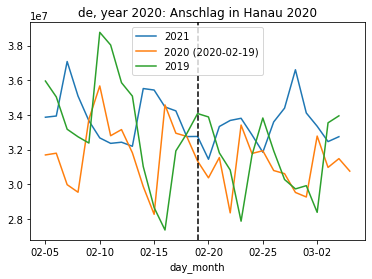

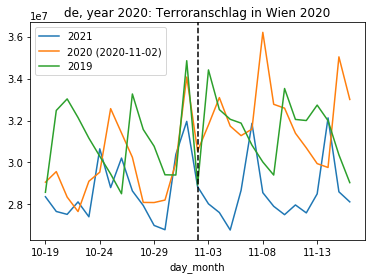

In [10]:
# Overall attention to wikipedia seems to not increase
event = 'Anschlag in Hanau 2020' # 'Attentato di Macerata'
code = 'de' # 'it' 
investigate_article_time(df, df_pageviews, event, code, interval=14, window=1)

event = 'Terroranschlag in Wien 2020' # 'Attentato di Macerata'
code = 'de' # 'it' 
investigate_article_time(df, df_pageviews, event, code, interval=14, window=3)

2018-01-20 2018-02-17
2016-07-02 2016-07-22


(datetime.date(2016, 7, 2), datetime.date(2016, 7, 22))

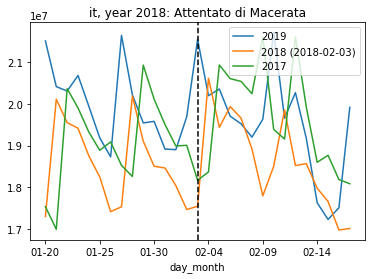

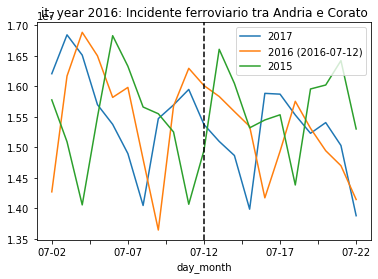

In [11]:
event = 'Attentato di Macerata'# 'Attentato di Vienna del 2020' # 
code = 'it' # 'it' 
investigate_article_time(df, df_pageviews, event, code, interval=14)

event = 'Incidente ferroviario tra Andria e Corato'
code = 'it' # 'it' 
investigate_article_time(df, df_pageviews, event, code, interval=10)

2020-10-19 2020-11-16
2018-01-31 2018-02-28


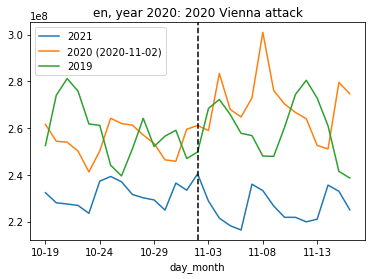

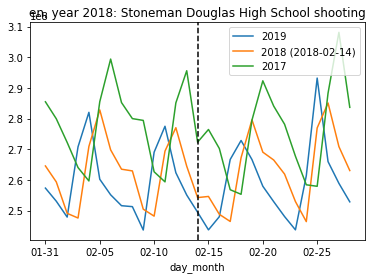

In [12]:
event = '2020 Vienna attack' # 'Attentato di Macerata'
code = 'en' # 'it' 
from_start, end_date = investigate_article_time(df, df_pageviews, event, code, interval=14)

event = 'Stoneman Douglas High School shooting' # 'Attentato di Macerata'
code = 'en' # 'it' 
from_start, end_date = investigate_article_time(df, df_pageviews, event, code, interval=14)